In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from collections import Counter
import copy
import random
import math

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
LEARNING_RATE = 0.01
NUM_CLIENTS = 5
LOCAL_ROUNDS = 10
GLOBAL_ROUNDS = 10
ALPHA = 0.1
SAMPLE_FRACTIONS = [0.5, 1]
BATCH_SIZE = 64
SEED_NUM = 47

torch.manual_seed(SEED_NUM)
random.seed(SEED_NUM)
np.random.seed(SEED_NUM)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_NUM)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.input_layer = nn.Conv2d(3,16,4,stride = 1)
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(3,32,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(64,256,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self, x):
        x = self.hidden_layer(x)
        return x

In [4]:
def state_dict_to_vector(state_dict):
    return torch.cat([v.flatten().cpu() for v in state_dict.values()])

def fed_avg(global_model, train_loaders, device, sample_fraction=1.0, lr=LEARNING_RATE):
    """
    Performs a single round of Federated Averaging (FedAvg).
    """
    criterion = nn.CrossEntropyLoss()
    num_clients = len(train_loaders)

    # 1. Client Selection
    n_clients = max(1, int(math.ceil(sample_fraction * num_clients)))
    selected_indices = sorted(random.sample(range(num_clients), n_clients))
    selected_loaders = [train_loaders[i] for i in selected_indices]

    global_model.to(device)
    global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    global_vec = state_dict_to_vector(global_state)

    # Calculate total data points of participating clients for weighted averaging
    participating_data = sum(len(loader.dataset) for loader in selected_loaders)

    # Accumulator for the weighted average of model deltas
    global_param_update = [torch.zeros_like(p.data) for p in global_model.parameters()]
    per_client_drifts = []

    # --- Each selected client trains locally ---
    for client_idx, loader in zip(selected_indices, selected_loaders):
        local_model = copy.deepcopy(global_model).to(device)
        optimizer = optim.SGD(local_model.parameters(), lr=lr)
        local_model.train()

        # --- Standard FedAvg Local Training Loop ---
        # (This loop uses the global LOCAL_ROUNDS variable from your script)
        for _ in range(LOCAL_ROUNDS):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = local_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # --- Compute updates and drift ---
        local_state = local_model.state_dict()
        local_vec = state_dict_to_vector(local_state)
        drift_norm = torch.norm(local_vec - global_vec, p=2).item()
        per_client_drifts.append(drift_norm)

        Ni = len(loader.dataset) # Number of data points for this client

        # Δw_i = w_i - w (model delta)
        delta_w_i = [p_local.data - p_global.data
                     for p_local, p_global in zip(local_model.parameters(), global_model.parameters())]

        # Accumulate the weighted model delta
        with torch.no_grad():
            for g_param, delta_w in zip(global_param_update, delta_w_i):
                # Weight by (Ni / N_total_participating)
                g_param += (Ni / participating_data) * delta_w

    # --- Server updates global model ---
    # The global update is the sum of the weighted deltas
    with torch.no_grad():
        for param, delta in zip(global_model.parameters(), global_param_update):
            param.data += delta

    avg_drift = float(np.mean(per_client_drifts))
    return avg_drift

def fed_sam(global_model, train_loaders, device, sample_fraction=1.0, lr=LEARNING_RATE, rho=0.05):
    """
    Performs a single round of Federated Averaging using FedSAM (Sharpness-Aware Minimization).
    
    Args:
        rho (float): Neighborhood radius parameter for SAM (perturbation size).
                     Assignment suggests start with rho = 0.5 * lr or small value like 0.05.
    """
    criterion = nn.CrossEntropyLoss()
    num_clients = len(train_loaders)

    # 1. Client Selection
    n_clients = max(1, int(math.ceil(sample_fraction * num_clients)))
    selected_indices = sorted(random.sample(range(num_clients), n_clients))
    selected_loaders = [train_loaders[i] for i in selected_indices]

    global_model.to(device)
    global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    global_vec = state_dict_to_vector(global_state)

    # Calculate total data points of participating clients for weighted averaging
    participating_data = sum(len(loader.dataset) for loader in selected_loaders)

    # Accumulator for the weighted average of model deltas
    global_param_update = [torch.zeros_like(p.data) for p in global_model.parameters()]
    per_client_drifts = []

    # --- Each selected client trains locally using SAM ---
    for client_idx, loader in zip(selected_indices, selected_loaders):
        local_model = copy.deepcopy(global_model).to(device)
        
        # Standard SGD optimizer for the final descent step
        optimizer = optim.SGD(local_model.parameters(), lr=lr)
        local_model.train()
        
        # Ensure gradients are zero before starting the loop
        optimizer.zero_grad()

        # --- FedSAM Local Training Loop ---
        for _ in range(LOCAL_ROUNDS):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                
                # --- Step 1: Ascent Step (Find Perturbation) ---
                
                # 1a. Compute initial gradients on original weights
                # Note: gradients are zero from previous step's cleanup or init
                outputs = local_model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                # 1b. Save current (original) weights to restore later
                # FIX: Save ALL trainable parameters, not just those with current grads
                original_weights = {}
                for name, param in local_model.named_parameters():
                    if param.requires_grad:
                        original_weights[name] = param.data.clone()

                # 1c. Compute perturbation and apply to weights (Ascent)
                # Formula: w_adv = w + rho * (grad / ||grad||)
                grad_norm = torch.norm(
                    torch.stack([p.grad.norm(p=2) for p in local_model.parameters() if p.grad is not None]), 
                    p=2
                )
                
                scale = rho / (grad_norm + 1e-12)

                with torch.no_grad():
                    for p in local_model.parameters():
                        if p.grad is not None:
                            # Apply perturbation: w = w + scale * grad
                            p.add_(p.grad * scale)

                # --- Step 2: Descent Step (Update Original Weights) ---
                
                optimizer.zero_grad() # Clear gradients from Step 1 (Ascent)
                
                # Compute gradients at perturbed weights
                outputs_adv = local_model(images)
                loss_adv = criterion(outputs_adv, labels)
                loss_adv.backward() # Gradients are now dL(w_adv)/dw_adv

                # Restore the original weights
                with torch.no_grad():
                    for name, param in local_model.named_parameters():
                        if name in original_weights:
                            param.data = original_weights[name] 
                            
                # Update weights using the gradients from w_adv
                optimizer.step()
                
                # FIX: Clear gradients immediately after step to keep state clean
                optimizer.zero_grad() 

        # --- Compute updates and drift (Same as FedAvg) ---
        local_state = local_model.state_dict()
        local_vec = state_dict_to_vector(local_state)
        drift_norm = torch.norm(local_vec - global_vec, p=2).item()
        per_client_drifts.append(drift_norm)

        Ni = len(loader.dataset)

        # Δw_i = w_i - w (model delta)
        delta_w_i = [p_local.data - p_global.data
                     for p_local, p_global in zip(local_model.parameters(), global_model.parameters())]

        # Accumulate the weighted model delta
        with torch.no_grad():
            for g_param, delta_w in zip(global_param_update, delta_w_i):
                # Weight by (Ni / N_total_participating)
                g_param += (Ni / participating_data) * delta_w

    # --- Server updates global model ---
    with torch.no_grad():
        for param, delta in zip(global_model.parameters(), global_param_update):
            param.data += delta

    avg_drift = float(np.mean(per_client_drifts))
    return avg_drift

In [5]:
def evaluate(model, test_loader, device):
  model.eval()
  correct, total, test_loss = 0, 0, 0
  criterion = nn.CrossEntropyLoss()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          test_loss += loss.item() * images.size(0)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return test_loss / total, 100 * correct / total

In [6]:
# !pip install fedlab

In [7]:
from fedlab.utils.dataset.partition import CIFAR10Partitioner

heter_loaders = []

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

hetero_dir_part = CIFAR10Partitioner(train_dataset.targets,
                                    NUM_CLIENTS,
                                    balance=None,
                                    partition="dirichlet",
                                    dir_alpha=ALPHA,
                                    seed=SEED_NUM)

heter_loaders = [
    DataLoader(Subset(train_dataset, hetero_dir_part.client_dict[i]), batch_size=BATCH_SIZE, shuffle=True)
    for i in range(NUM_CLIENTS)
]

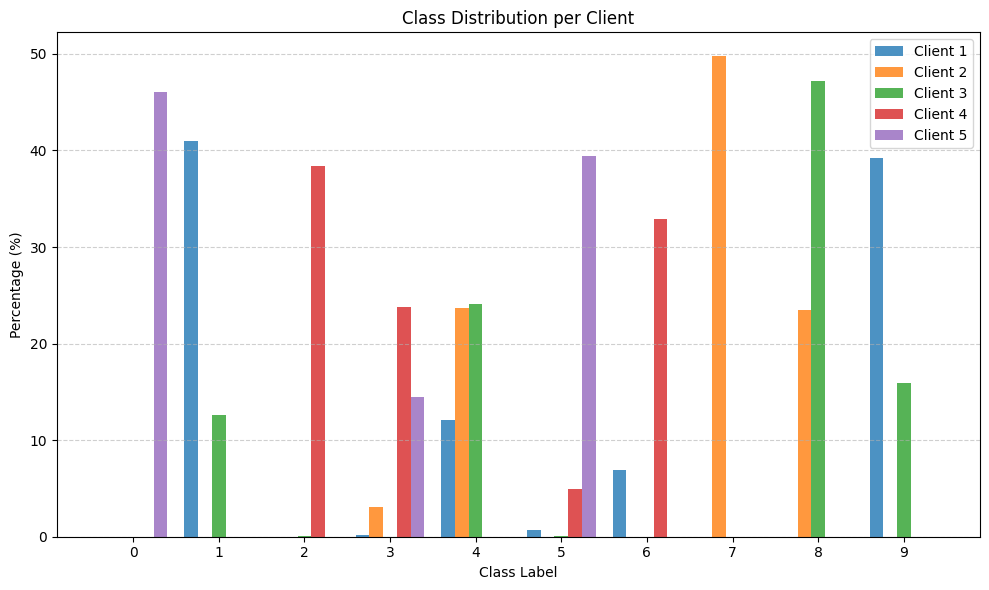

In [8]:

def plot_class_distributions(train_loaders, num_classes=10):
    class_dists = []

    # compute class percentage for each client
    for loader in train_loaders:
        if hasattr(loader.dataset, 'targets'):
            labels = loader.dataset.targets
        elif hasattr(loader.dataset, 'labels'):
            labels = loader.dataset.labels
        else:
            labels = []
            for _, y in loader:
                labels.extend(y.tolist())
            labels = torch.tensor(labels)

        counts = Counter(labels.tolist())
        total = sum(counts.values())
        percents = [counts.get(c, 0) / total * 100 for c in range(num_classes)]
        class_dists.append(percents)

    # plot
    class_labels = np.arange(num_classes)
    width = 0.8 / len(train_loaders)  # to fit all clients side-by-side

    plt.figure(figsize=(10, 6))
    for i, dist in enumerate(class_dists):
        plt.bar(class_labels + i * width, dist, width=width, label=f'Client {i+1}', alpha=0.8)

    plt.xticks(class_labels + width*(len(train_loaders)/2 - 0.5), [str(i) for i in range(num_classes)])
    plt.xlabel("Class Label")
    plt.ylabel("Percentage (%)")
    plt.title("Class Distribution per Client")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_class_distributions(heter_loaders, num_classes=10)

In [9]:
clients = [0,1,2,3,4]
client_train_loaders = heter_loaders

In [10]:
import pickle
with open("Results/Scaf/accuracies_fedav.pkl", "rb") as f:
    accuracies_fedav = pickle.load(f)
with open("Results/Scaf/drifts_fedav.pkl", "rb") as f:
    drifts_fedav = pickle.load(f)

accuracies_sam = {}
drifts_sam = {}
for sample in SAMPLE_FRACTIONS:
    sam_global_model = SimpleCNN()
    sam_global_model.to(device)
    accuracies_sam[sample] = []
    drifts_sam[sample] = []
    print(f"\n SAMPLE FRACTION = {sample}")
    for round in range(GLOBAL_ROUNDS):
        print(f"Round {round+1}:")
        print(f"    FedAvg: Test Acc: {accuracies_fedav[sample][round]:.2f}%, Avg Drift: {drifts_fedav[sample][round]:.4f}")
        sam_drift = fed_sam(sam_global_model, client_train_loaders, device, sample_fraction=sample, rho=0.05)
        drifts_sam[sample].append(sam_drift)
        sam_loss, sam_acc = evaluate(sam_global_model, test_loader, device)
        accuracies_sam[sample].append(sam_acc)
        print(f"    FedSAM: Test Loss: {sam_loss:.4f}, Test Acc: {sam_acc:.2f}%, Avg Drift: {sam_drift:.4f}")


 SAMPLE FRACTION = 0.5
Round 1:
    FedAvg: Test Acc: 11.23%, Avg Drift: 2.0511
    FedSAM: Test Loss: 2.6819, Test Acc: 19.04%, Avg Drift: 2.0687
Round 2:
    FedAvg: Test Acc: 13.20%, Avg Drift: 1.8708
    FedSAM: Test Loss: 2.5037, Test Acc: 11.50%, Avg Drift: 2.0767
Round 3:
    FedAvg: Test Acc: 27.64%, Avg Drift: 1.7150
    FedSAM: Test Loss: 2.9149, Test Acc: 17.26%, Avg Drift: 1.6851
Round 4:
    FedAvg: Test Acc: 21.43%, Avg Drift: 1.4318
    FedSAM: Test Loss: 2.8845, Test Acc: 23.61%, Avg Drift: 1.4985
Round 5:
    FedAvg: Test Acc: 28.33%, Avg Drift: 1.5447
    FedSAM: Test Loss: 2.1728, Test Acc: 31.44%, Avg Drift: 1.6375
Round 6:
    FedAvg: Test Acc: 33.41%, Avg Drift: 1.5654
    FedSAM: Test Loss: 2.3448, Test Acc: 32.40%, Avg Drift: 1.4952
Round 7:
    FedAvg: Test Acc: 28.61%, Avg Drift: 1.3880
    FedSAM: Test Loss: 2.5876, Test Acc: 29.61%, Avg Drift: 1.3353
Round 8:
    FedAvg: Test Acc: 42.78%, Avg Drift: 1.5005
    FedSAM: Test Loss: 1.7215, Test Acc: 43.40%, Av

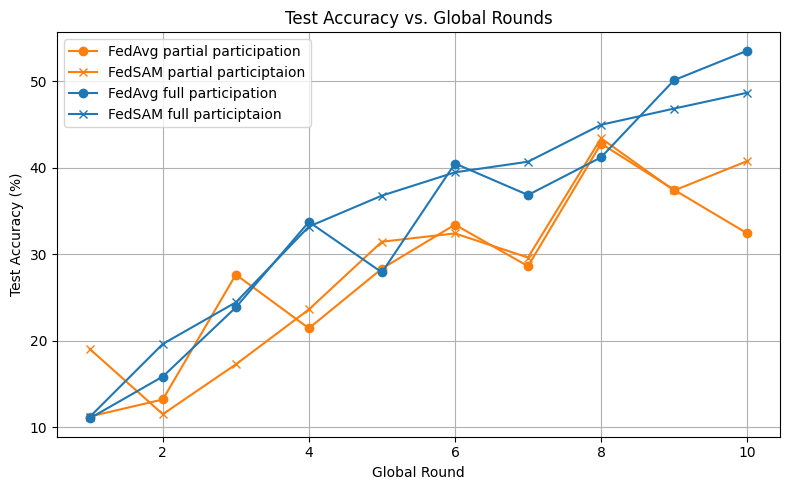

In [11]:
rounds = list(range(1, 11))

# --- Plot 1: Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(rounds, accuracies_fedav[0.5], marker='o', color='tab:orange', label='FedAvg partial participation')
plt.plot(rounds, accuracies_sam[0.5], marker='x', color='tab:orange', label='FedSAM partial participtaion')
plt.plot(rounds, accuracies_fedav[1], marker='o', color='tab:blue', label='FedAvg full participation')
plt.plot(rounds, accuracies_sam[1], marker='x', color='tab:blue', label='FedSAM full participtaion')
plt.title('Test Accuracy vs. Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

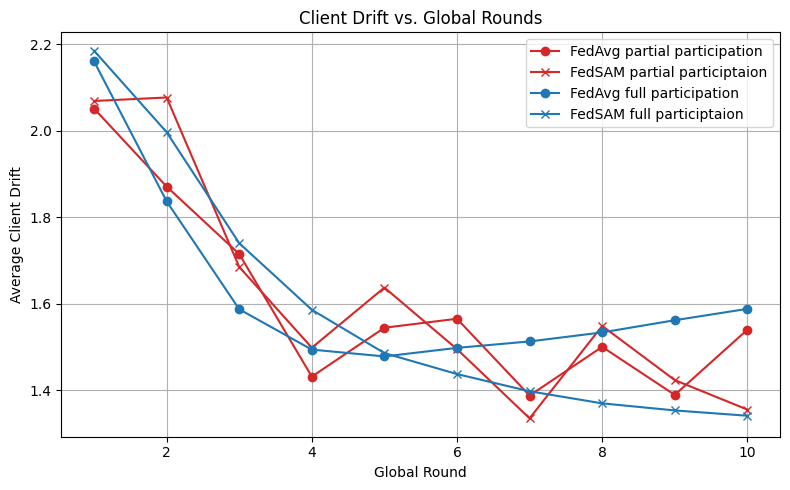

In [12]:
plt.figure(figsize=(8,5))
plt.plot(rounds, drifts_fedav[0.5], marker='o', color='tab:red', label='FedAvg partial participation')
plt.plot(rounds, drifts_sam[0.5], marker='x', color='tab:red', label='FedSAM partial participtaion')
plt.plot(rounds, drifts_fedav[1], marker='o', color='tab:blue', label='FedAvg full participation')
plt.plot(rounds, drifts_sam[1], marker='x', color='tab:blue', label='FedSAM full participtaion')
plt.title('Client Drift vs. Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Average Client Drift')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()